This notebook is to deal with training the model to predict the race, age, and gender from the input human face input.

The dataset source is here: https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv

Import the libraries here

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


In [2]:
import keras
import json
import sys
import tensorflow as tf
from keras.layers import Input
import argparse
from keras.utils.data_utils import get_file

In [3]:
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense, Lambda
from keras.layers import Input, Flatten
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


The dataset is a csv file
Each row is defined as age ethnicity, gender, img_name, and the matrix of pixels

In [4]:
df = pd.read_csv("age_gender.csv")
df.head()
print(len(df))

23705


Here we display one image to see what's stored in the dataset.

(-0.5, 47.5, 47.5, -0.5)

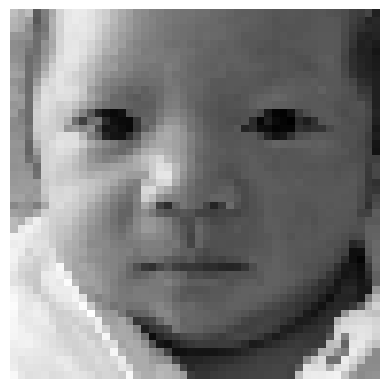

In [5]:
df_data= pd.DataFrame(df)
df_data['pixels'] = df_data.pixels.apply(lambda x: np.reshape(np.array(x.split(' '),dtype='float32'),(48,48)))
im = df_data['pixels'][30]
plt.imshow(im, cmap='gray')
plt.axis('off')

Get the three input data columns => gender, race, and age
And also, display the unique lables of each one
To be clear, this is where we do normalization place.

In [6]:
gender = df_data['gender']
race = df_data['ethnicity']
age = df_data['age']
images = df_data['pixels']/255 # do normalization
images = list(images)
resized_images = []
for i in images:
    temp = np.resize(i, (224,224,1))
    resized_images.append(temp)
images = np.array(list(images))
resized_images = np.array(resized_images)

print("original images shape: ", images.shape)
print("resized images shape:", resized_images.shape)

original images shape:  (23705, 48, 48)
resized images shape: (23705, 224, 224, 1)


In [7]:
display(gender.unique())
display(race.unique())
display(age.unique())

gender_num = gender.unique().shape[0]
race_num = race.unique().shape[0]
age_num = age.unique().shape[0]

array([0, 1], dtype=int64)

array([2, 3, 4, 0, 1], dtype=int64)

array([  1,  10, 100, 101, 103, 105,  11, 110, 111, 115, 116,  12,  13,
        14,  15,  16,  17,  18,  19,   2,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,   3,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,   4,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
         5,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,   6,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,   7,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,   8,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,   9,  90,  91,  92,  93,  95,  96,  99],
      dtype=int64)

In [8]:
gender_array = gender.to_numpy()
race_array = race.to_numpy()
age_array = age.to_numpy()
max_age = np.max(age_array)
min_age = np.min(age_array)
print(gender_array.shape)
print(race_array.shape)
print(age_array.shape)

(23705,)
(23705,)
(23705,)


Separate the index of input dataset in train/valid/test split by 70:10:20

In [9]:
random_indexes = np.random.permutation(len(df_data))
train_up_to = int(len(df_data) * 0.7)
valid_up_to = train_up_to + int(len(df_data) * 0.1)

train_indexes = random_indexes[:train_up_to]
valid_indexes = random_indexes[train_up_to:valid_up_to]
test_indexes = random_indexes[valid_up_to:]

print("Length of train, valid, test set indexes are {}, {}, {}".format(len(train_indexes), len(valid_indexes), len(test_indexes)))

Length of train, valid, test set indexes are 16593, 2370, 4742


Define a image generator

In [10]:
def data_generator(list_index, check, batch_size, gender_array, race_array, age_array, resized_images):
    images, ages, races, genders = [], [], [], []
    while True:
        for idx in list_index:
            gender = gender_array[idx]
            age = age_array[idx]
            race = race_array[idx]
            image = resized_images[idx]

            genders.append(to_categorical(gender, gender_num))
            ages.append(age/max_age)
            races.append(to_categorical(race, race_num))
            images.append(image)

            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not check:
            break

In [11]:
class MultiOutputModel():

    def make_hidden_layers(self, inputs):
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        return x
    def race_branch(self, inputs):
        x = self.make_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(5)(x)
        x = Activation("softmax", name="race_output")(x)
        return x
    def gender_branch(self, inputs, num_genders=2):
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
        x = self.make_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)
        return x
    def age_branch(self, inputs):
        x = self.make_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)
        return x
    def assemble(self, width, height):
        input_shape = (height, width, 1)
        inputs = Input(shape=input_shape)
        age_branch = self.age_branch(inputs)
        race_branch = self.race_branch(inputs)
        gender_branch = self.gender_branch(inputs)
        model = Model(inputs=inputs,
                      outputs = [age_branch, race_branch, gender_branch],
                      name="Face_network")
        return model


In [12]:
model = MultiOutputModel().assemble(224, 224)

Here is to display the structure of the model

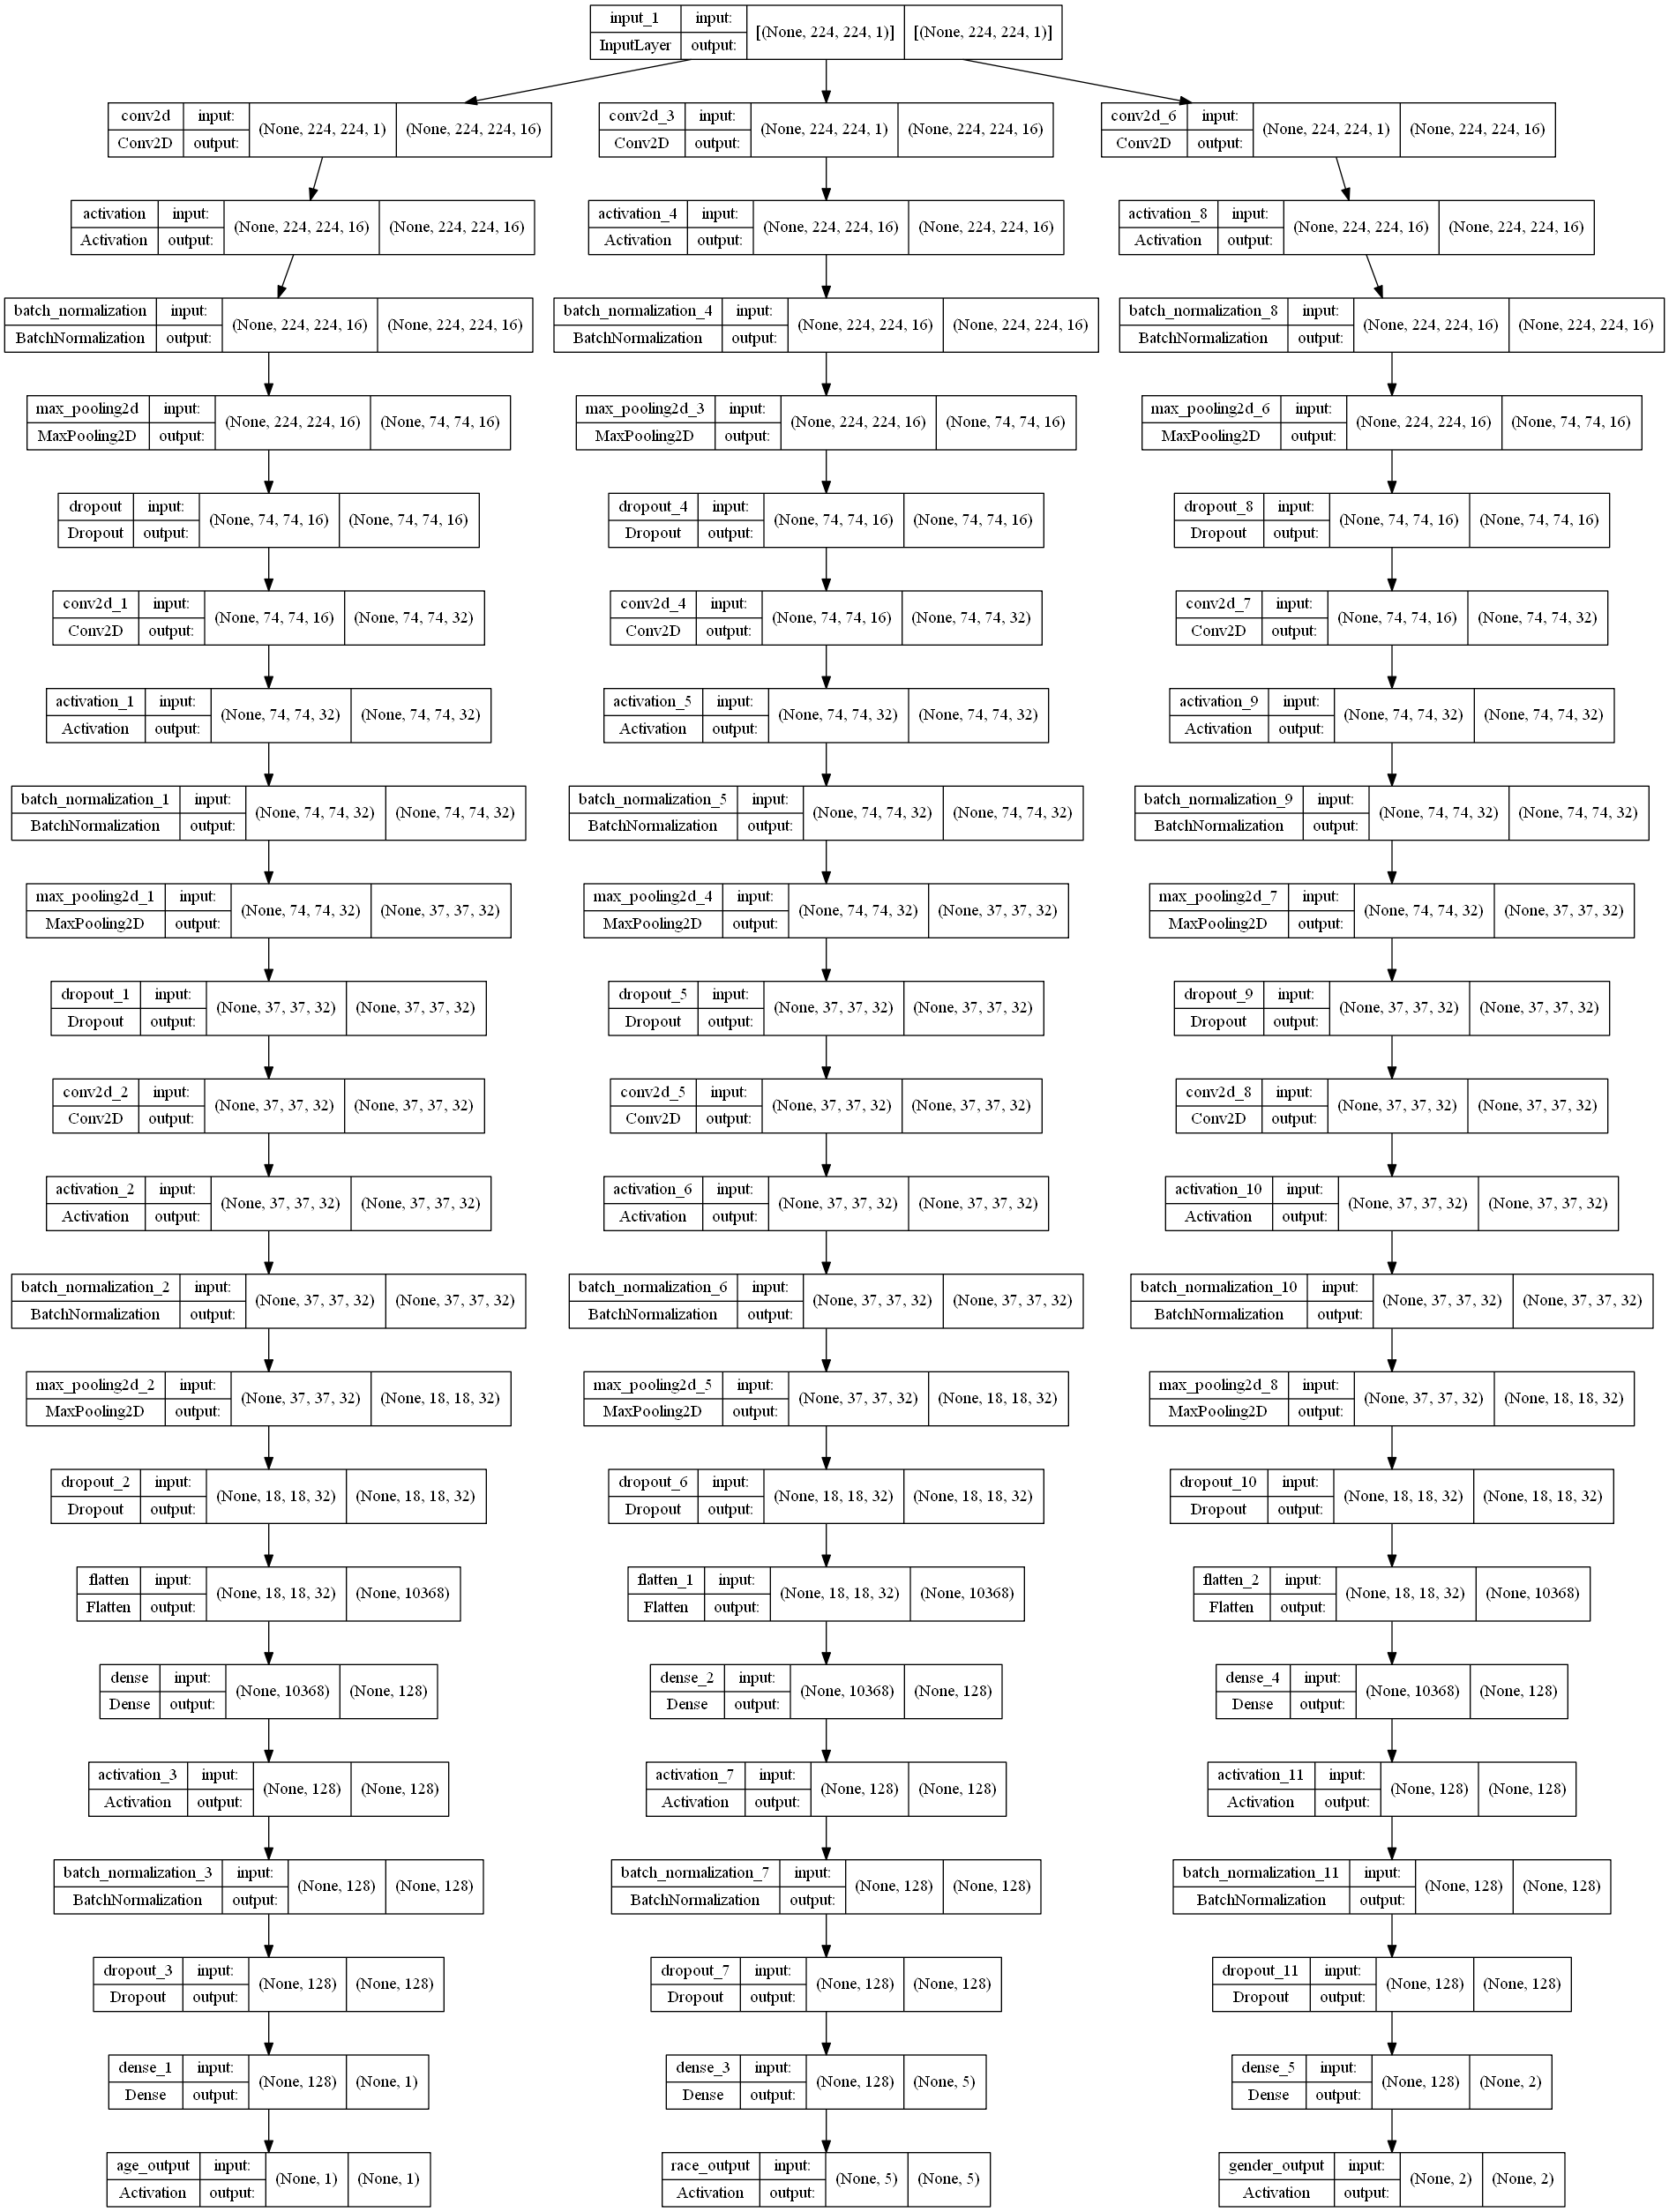

In [13]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

Define the optimizers, learning rate, and loss function of the model

In [29]:
learning_rate = 1e-4
epochs = 100
opt = Adam(lr=learning_rate, decay=learning_rate / epochs)
model.compile(optimizer=opt,
              loss={
                  'age_output': 'mse',
                  'race_output': 'categorical_crossentropy',
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 3.,
                  'race_output': 2,
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae',
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

In [30]:
batch_size = 32
valid_batch_size = 32

train_generator = data_generator(list_index=train_indexes, check=True, batch_size=32, gender_array=gender_array, race_array=race_array, age_array=age_array, resized_images=resized_images)

valid_generator = data_generator(list_index=valid_indexes, check=True, batch_size=32, gender_array=gender_array, race_array=race_array, age_array=age_array, resized_images=resized_images)

In [31]:
callbacks = [
    ModelCheckpoint("./checkpoints", monitor='val_loss')
]
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_indexes)//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=valid_generator,
                              validation_steps=len(valid_indexes)//valid_batch_size)

Epoch 1/100


C:\Users\Felix\AppData\Local\Temp\ipykernel_22756\4259126200.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


ValueError: in user code:

    File "C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\engine\training.py", line 864, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\engine\compile_utils.py", line 438, in update_state
        self.build(y_pred, y_true)
    File "C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\engine\compile_utils.py", line 358, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(y_pred, self._get_metric_objects,
    File "C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\engine\compile_utils.py", line 484, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\engine\compile_utils.py", line 484, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\engine\compile_utils.py", line 503, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\metrics.py", line 4262, in get
        return deserialize(str(identifier))
    File "C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\metrics.py", line 4218, in deserialize
        return deserialize_keras_object(
    File "C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\utils\generic_utils.py", line 709, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown metric function: prec. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


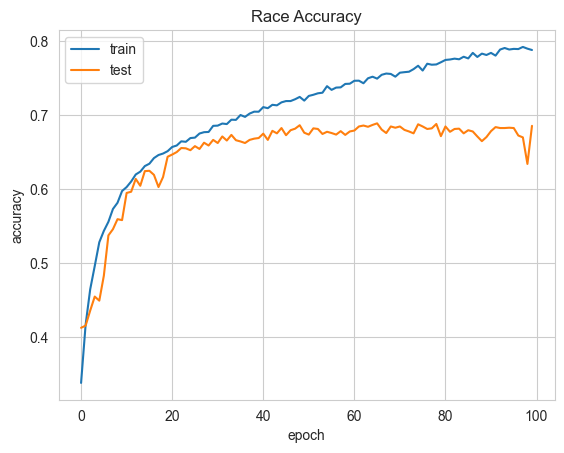

In [17]:
plt.plot(history.history['race_output_accuracy'])
plt.plot(history.history['val_race_output_accuracy'])
plt.title('Race Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

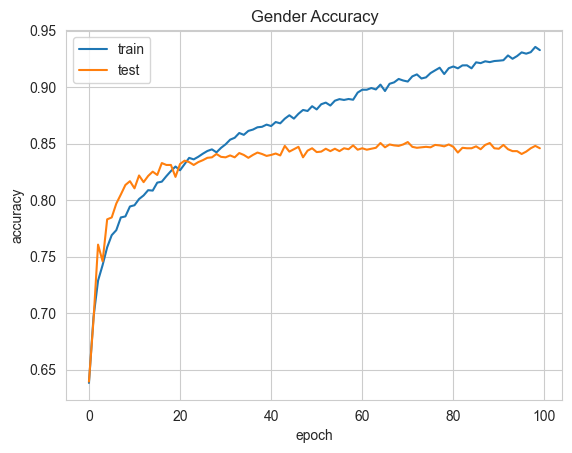

In [18]:
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

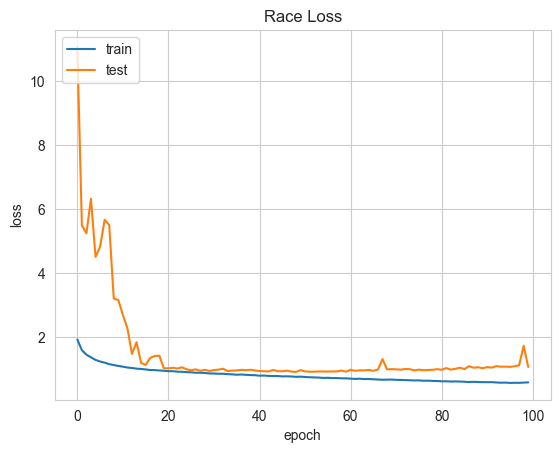

In [21]:
plt.plot(history.history['race_output_loss'])
plt.plot(history.history['val_race_output_loss'])
plt.title('Race Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

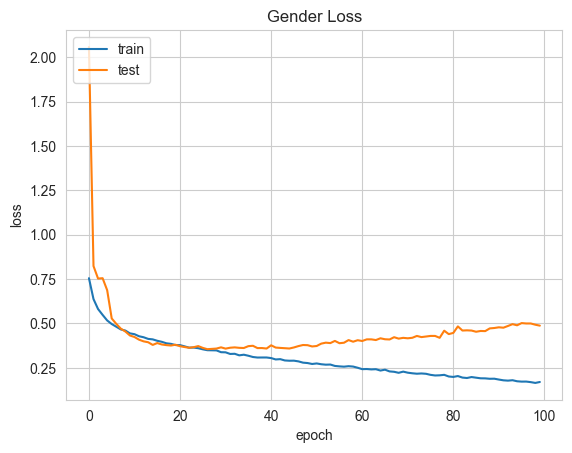

In [22]:
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('Gender Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

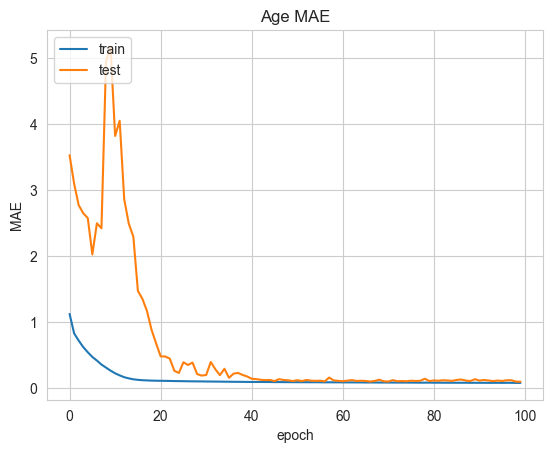

In [23]:
plt.plot(history.history['age_output_mae'])
plt.plot(history.history['val_age_output_mae'])
plt.title('Age MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

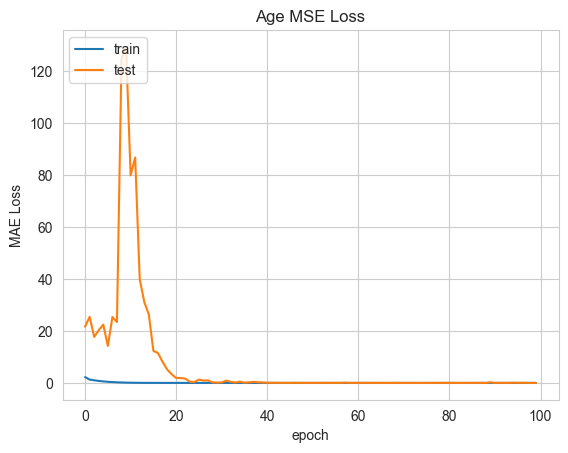

In [24]:
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('Age MSE Loss')
plt.ylabel('MAE Loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

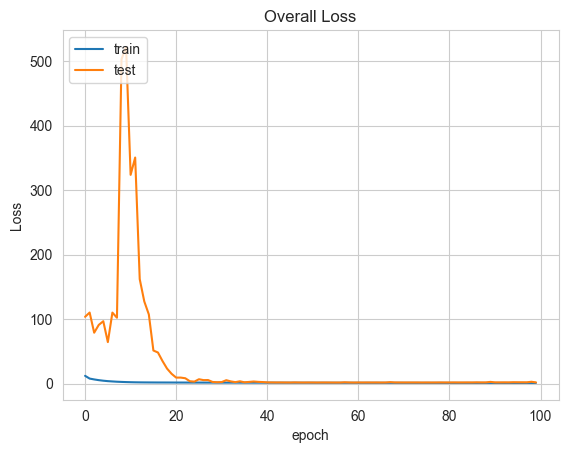

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Overall Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [38]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints/saved_model.pb',
                                                 save_weights_only=False,
                                                 verbose=1)


In [45]:
test_generator = data_generator(list_index=test_indexes, check=True, batch_size=32, gender_array=gender_array, race_array=race_array, age_array=age_array, resized_images=resized_images)

In [47]:
metrics_model = model = MultiOutputModel().assemble(224, 224)
learning_rate = 1e-4
epochs = 1
opt = Adam(lr=learning_rate, decay=learning_rate / epochs)
metrics_model.compile(optimizer=opt,
              loss={
                  'age_output': 'mse',
                  'race_output': 'categorical_crossentropy',
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4.,
                  'race_output': 2,
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae',
                  'race_output': tf.keras.metrics.Precision(), ## or recall
                  'gender_output': tf.keras.metrics.Precision()}) ## recall
metrics_model.fit(train_generator,
                  steps_per_epoch=len(train_indexes)//batch_size,
                  epochs=epochs,
                  callbacks=cp_callback,
                  validation_data=test_generator,
                  validation_steps=len(valid_indexes)//valid_batch_size)

C:\Users\Felix\anaconda3\envs\tf2x\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


518/518 [==============================] - ETA: 0s - loss: 10.9024 - age_output_loss: 1.9816 - race_output_loss: 1.9311 - gender_output_loss: 0.7928 - age_output_acc: 6.0328e-05 - race_output_precision_10: 0.3865 - gender_output_precision_11: 0.6025
Epoch 1: saving model to checkpoints\saved_model.pb
518/518 [==============================] - 40s 74ms/step - loss: 10.9024 - age_output_loss: 1.9816 - race_output_loss: 1.9311 - gender_output_loss: 0.7928 - age_output_acc: 6.0328e-05 - race_output_precision_10: 0.3865 - gender_output_precision_11: 0.6025 - val_loss: 442.1755 - val_age_output_loss: 106.4143 - val_race_output_loss: 10.7029 - val_gender_output_loss: 4.6381 - val_age_output_acc: 0.0000e+00 - val_race_output_precision_10: 0.4069 - val_gender_output_precision_11: 0.6593
